(stats_tutorial)=
# Intro to the stats module

In [1]:
from scipy import stats
import numpy as np
from xarray_einstats.stats import XrContinuousRV, rankdata, hmean, skew, median_abs_deviation
from xarray_einstats.tutorial import generate_mcmc_like_dataset

In [2]:
ds = generate_mcmc_like_dataset(11)

(stats_tutorial/dists)=
## Probability distributions
### Initialization


In [3]:
norm = XrContinuousRV(stats.norm, ds["mu"], ds["sigma"])

### Using its methods
Once initialized, you can use its methods exactly as you'd use them with scipy distributions. The only two differences are
1. They now take scalars or DataArrays as inputs, arrays are only accepted as the arguments
   on which to evaluate the methods (in scipy docs they are represented by `x`, `k` or `q` depending on the method)
2. `size` behaves differently in the `rvs` method. This ensures that you don't need to care about any broadcasting or alignment of arrays, `xarray_einstats` does this for you.

You can generate 10 random draws from the initialized distribution. Here, unlike what would happen with scipy, the output won't have shape 10, but instead will have shape `10, *broadcasted_input_shape`. xarray generates the `broadcasted_input_shape` and `size` is independent from it so you can relax and not care about broadcasting.

In [4]:
norm.rvs(size=(10))

<xarray.DataArray (rv_dim0: 10, chain: 4, draw: 10, team: 6)>
-0.5462 1.221 0.7538 -0.1699 0.008793 ... 0.2442 -0.1568 0.03705 1.022 2.371
Coordinates:
  * team     (team) <U1 'a' 'b' 'c' 'd' 'e' 'f'
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: rv_dim0

If the dimension names are not provided, `xarray_einstats` assings `rv_dim#` as dimension name as many times as necessary. To define the names manually you can use the `dims` argument:

In [5]:
norm.rvs(size=(5, 3), dims=["subject", "batch"])

<xarray.DataArray (subject: 5, batch: 3, chain: 4, draw: 10, team: 6)>
-0.3871 0.1645 0.8031 -0.4782 -0.5517 ... 0.477 -0.5015 -0.1281 0.04756 1.946
Coordinates:
  * team     (team) <U1 'a' 'b' 'c' 'd' 'e' 'f'
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: subject, batch

The behaviour for other methods is similar:

In [6]:
norm.logcdf(ds["x_plot"])

<xarray.DataArray (plot_dim: 20, chain: 4, draw: 10, team: 6)>
-1.318 -2.617 -6.71 -0.7968 ... -1.248e-263 -7.905e-247 -1.896e-242 -1.636e-170
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9
  * team     (team) <U1 'a' 'b' 'c' 'd' 'e' 'f'
Dimensions without coordinates: plot_dim

For convenience, you can also use {term}`array_like` input which is converted to a DataArray under the hood. In such cases, the dimension name is `quantile` for `ppf` and `isf`, `point` otherwise. In both cases, the values passed as input are preserved as coordinate values.

In [7]:
norm.ppf([.25, .5, .75])

<xarray.DataArray (quantile: 3, chain: 4, draw: 10, team: 6)>
-0.02018 0.2885 0.8726 -0.204 -0.1332 ... 0.2786 0.2264 0.5523 0.6391 2.198
Coordinates:
  * quantile  (quantile) float64 0.25 0.5 0.75
  * chain     (chain) int64 0 1 2 3
  * draw      (draw) int64 0 1 2 3 4 5 6 7 8 9
  * team      (team) <U1 'a' 'b' 'c' 'd' 'e' 'f'

In [8]:
pdf = norm.pdf(np.linspace(-5, 5))
pdf

<xarray.DataArray (point: 50, chain: 4, draw: 10, team: 6)>
5.321e-44 2.898e-49 4.753e-60 5.206e-41 ... 3.563e-57 4.449e-55 3.664e-24
Coordinates:
  * point    (point) float64 -5.0 -4.796 -4.592 -4.388 ... 4.388 4.592 4.796 5.0
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9
  * team     (team) <U1 'a' 'b' 'c' 'd' 'e' 'f'

Plot a subset of the pdf we just calculated with matplotlib.

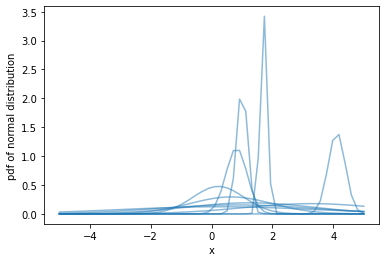

In [9]:
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "white"

fig, ax = plt.subplots()
ax.plot(pdf.point, pdf.sel(team="d", chain=2), color="C0", alpha=.5)
ax.set(xlabel="x", ylabel="pdf of normal distribution", );

(stats_tutorial/other)=
## Other functions
The rest of the functions in the module have a very similar API to their scipy counterparts, the only differences are:

* They take `dims` instead of `axis`. Moreover, `dims` can be `str` or a sequence of `str` instead of a single integer only as supported by `axis`.
* Arguments that take {term}`numpy:array_like` as values take `DataArray` inputs instead. For example the `scale` argument in {func}`~xarray_einstats.stats.median_abs_deviation`
* They accept extra arbitrary kwargs, that are passed to {func}`xarray.apply_ufunc`.

Here are some examples of using functions in the `stats` module of `xarray_einstats` with `dims` argument instead of `axis`.

In [10]:
hmean(ds["mu"], dims="team")

<xarray.DataArray 'mu' (chain: 4, draw: 10)>
0.1588 0.2123 0.5543 0.7826 0.1913 0.6035 ... 0.1269 0.712 0.3044 0.1936 0.1223
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9

In [11]:
rankdata(ds["score"], dims=("chain", "draw"), method="min")

<xarray.DataArray 'score' (match: 12, chain: 4, draw: 10)>
14 14 14 14 14 31 14 1 31 14 31 1 14 1 ... 15 15 15 15 15 1 34 15 15 1 34 34 34
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: match

:::{important}
The statistical summaries and other statistical functions can take both {class}`~xarray.DataArray` and {class}`~xarray.Dataset`. Methods in probability functions and functions in linear algebra module
are tested only on `DataArray`s.

When using `Dataset` inputs, you must make sure that all the dimensions in `dims` are
present in _all_ the `DataArray`s within the `Dataset`.
:::

In [12]:
skew(ds[["score", "mu", "sigma"]], dims=("chain", "draw"))

<xarray.Dataset>
Dimensions:  (match: 12, team: 6)
Coordinates:
  * team     (team) <U1 'a' 'b' 'c' 'd' 'e' 'f'
Dimensions without coordinates: match
Data variables:
    score    (match) float64 1.466 0.2149 0.6788 1.361 ... 1.099 1.156 1.265
    mu       (team) float64 0.8152 1.84 2.102 1.806 1.091 0.9678
    sigma    float64 1.314

In [13]:
median_abs_deviation(ds)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    x_plot   float64 2.632
    mu       float64 0.4878
    sigma    float64 0.39
    score    float64 1.0

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray_einstats,xarray

Last updated: Sun Jun 19 2022

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.4.0

xarray_einstats: 0.3.0
xarray         : 2022.3.0

numpy     : 1.22.4
scipy     : 1.8.1
matplotlib: 3.5.2

Watermark: 2.3.1

